In [1]:
import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_1d_slice, plot_spacetime, OutputLoader
from superfv.initial_conditions import shu_osher

In [2]:
T = 0.178
N = 400
Nref = 10000
overwrite = False

base_path = "/scratch/gpfs/jp7427/out/shu-osher/"

In [25]:
common = dict(PAD={"rho": (0, None), "P": (0, None)})
musclhancock = dict(p=1, MUSCL=True, **common)
apriori = dict(ZS=True, lazy_primitives="adaptive", **common)
aposteriori = dict(
    MOOD=True,
    face_fallback=False,
    lazy_primitives="full",
    MUSCL_limiter="moncen",
    **common,
)
aposteriori1 = dict(cascade="muscl", max_MOOD_iters=1, **aposteriori)
aposteriori2 = dict(cascade="muscl1", max_MOOD_iters=2, **aposteriori)
aposteriori3 = dict(cascade="muscl1", max_MOOD_iters=3, **aposteriori)

no_v = dict(limiting_vars=("rho", "P"))

configs = {
    "ref": dict(MUSCL_limiter="moncen", **musclhancock),
    "MUSCL-Hancock": dict(MUSCL_limiter="moncen", **musclhancock),
    "ZS3": dict(p=3, **apriori),
    "ZS7": dict(p=7, **apriori),
    "ZS3/no_SED": dict(p=3, SED=False, **apriori),
    "ZS7/no_SED": dict(p=7, SED=False, **apriori),
    "MM3/1rev/no_NAD": dict(p=3, NAD=False, SED=False, **aposteriori1),
    "MM7/1rev/no_NAD": dict(p=7, NAD=False, SED=False, **aposteriori1),
    "MM3/1rev/rtol_1e-2": dict(p=3, NAD_rtol=1e-2, **aposteriori1),
    "MM7/1rev/rtol_1e-2": dict(p=7, NAD_rtol=1e-2, **aposteriori1),
    "MM3/1rev/no_delta/rtol_1e-5": dict(
        p=3, NAD_delta=False, NAD_rtol=1e-5, **aposteriori1
    ),
    "MM7/1rev/no_delta/rtol_1e-5": dict(
        p=7, NAD_delta=False, NAD_rtol=1e-5, **aposteriori1
    ),
    "MM3/1rev/no_delta/rtol_1e-3": dict(
        p=3, NAD_delta=False, NAD_rtol=1e-3, **aposteriori1
    ),
    "MM7/1rev/no_delta/rtol_1e-3": dict(
        p=7, NAD_delta=False, NAD_rtol=1e-3, **aposteriori1
    ),
    "MM3/1rev/no_delta/rtol_1e-2": dict(
        p=3, NAD_delta=False, NAD_rtol=1e-2, **aposteriori1
    ),
    "MM7/1rev/no_delta/rtol_1e-2": dict(
        p=7, NAD_delta=False, NAD_rtol=1e-2, **aposteriori1
    ),
    "MM3/1rev/no_delta/rtol_1e-1": dict(
        p=3, NAD_delta=False, NAD_rtol=1e-1, **aposteriori1
    ),
    "MM7/1rev/no_delta/rtol_1e-1": dict(
        p=7, NAD_delta=False, NAD_rtol=1e-1, **aposteriori1
    ),
    "MM3/1rev/no_delta/rtol_1e0": dict(
        p=3, NAD_delta=False, NAD_rtol=1e0, **aposteriori1
    ),
    "MM7/1rev/no_delta/rtol_1e0": dict(
        p=7, NAD_delta=False, NAD_rtol=1e0, **aposteriori1
    ),
}

In [26]:
sims = {}
for name, config in configs.items():
    sim_path = f"{base_path}{name}"

    if not overwrite:
        try:
            sim = OutputLoader(sim_path)
            sims[name] = sim
            continue
        except FileNotFoundError:
            pass

    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=shu_osher,
        bcx="free",
        nx=Nref if name == "ref" else N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            path=sim_path,
            allow_overshoot=True,
            snapshot_mode="target" if name == "ref" else "every",
        )
    except Exception as e:
        print(f"Simulation {name} failed: {e}")
        continue

    sims[name] = sim

Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/ref"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/MUSCL-Hancock"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/ZS3"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/ZS7"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/ZS3/no_SED"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/ZS7/no_SED"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/MM3/1rev/no_NAD"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/MM7/1rev/no_NAD"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/MM3/1rev/rtol_1e-2"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/MM7/1rev/rtol_1e-2"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/shu-osher/MM3/1rev/no_delta/rtol_1e

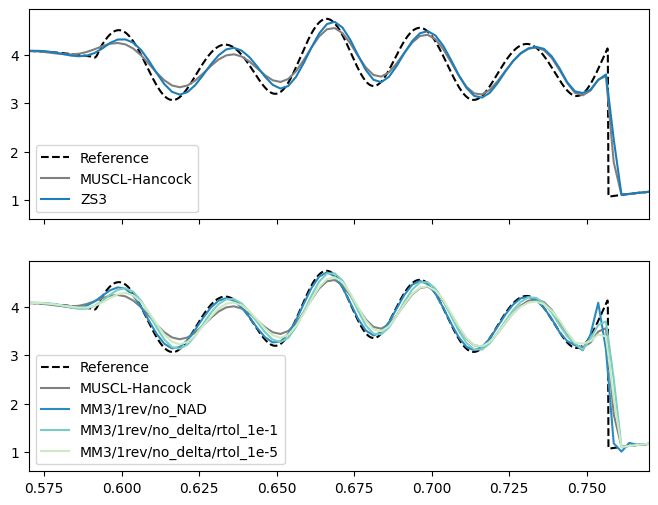

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6))
axs[0].set_xlim(0.57, 0.77)

cmap = plt.get_cmap("GnBu")

plot_1d_slice(sims["ref"], axs[0], "rho", color="k", linestyle="--", label="Reference")
plot_1d_slice(sims["MUSCL-Hancock"], axs[0], "rho", color="grey", label="MUSCL-Hancock")
plot_1d_slice(sims["ZS3"], axs[0], "rho", color=cmap(0.8), label="ZS3")

plot_1d_slice(sims["ref"], axs[1], "rho", color="k", linestyle="--", label="Reference")
plot_1d_slice(sims["MUSCL-Hancock"], axs[1], "rho", color="grey", label="MUSCL-Hancock")
plot_1d_slice(
    sims["MM3/1rev/no_NAD"], axs[1], "rho", color=cmap(0.75), label="MM3/1rev/no_NAD"
)
plot_1d_slice(
    sims["MM3/1rev/no_delta/rtol_1e-1"],
    axs[1],
    "rho",
    color=cmap(0.5),
    label="MM3/1rev/no_delta/rtol_1e-1",
)
plot_1d_slice(
    sims["MM3/1rev/no_delta/rtol_1e-5"],
    axs[1],
    "rho",
    color=cmap(0.25),
    label="MM3/1rev/no_delta/rtol_1e-5",
)

axs[0].legend()
axs[1].legend()

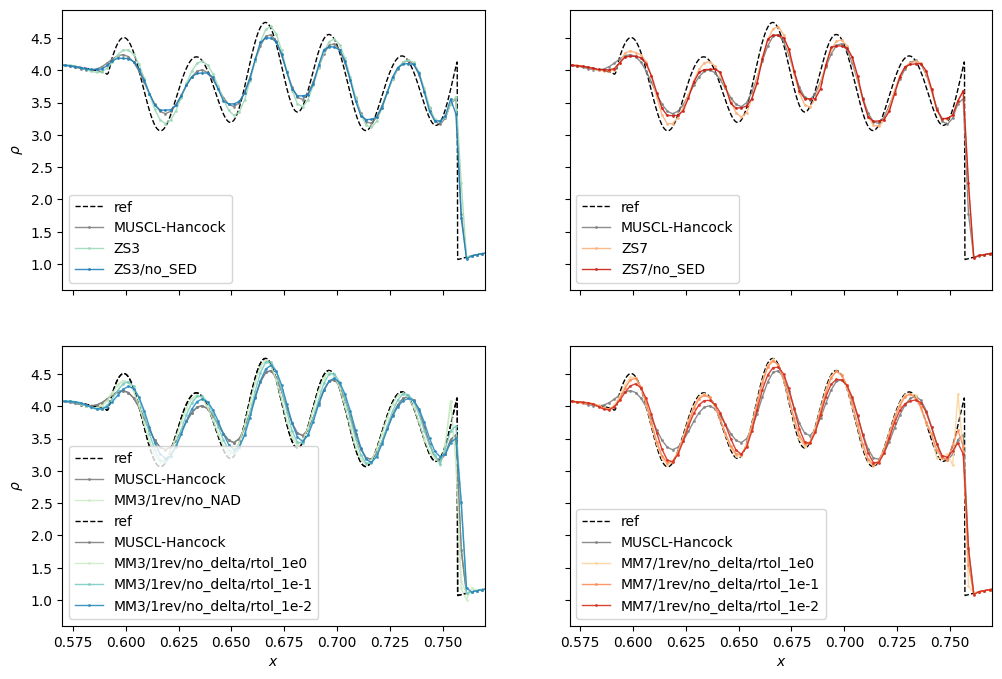

In [27]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
axs[1, 0].set_xlabel(r"$x$")
axs[1, 1].set_xlabel(r"$x$")
axs[0, 0].set_ylabel(r"$\rho$")
axs[1, 0].set_ylabel(r"$\rho$")
axs[0, 0].set_xlim(0.57, 0.77)

cmap1 = plt.get_cmap("GnBu")
cmap2 = plt.get_cmap("OrRd")


def plot(name, ax, v, style=dict()):
    plot_1d_slice(
        sims[name],
        ax,
        v,
        label=name,
        linewidth=1,
        markersize=1,
        marker="none" if name == "ref" else "o",
        mfc="none",
        alpha=1 if name == "ref" else 0.9,
        **style,
    )


plot("ref", axs[0, 0], "rho", dict(color="k", linestyle="--"))
plot("MUSCL-Hancock", axs[0, 0], "rho", dict(color="grey"))
plot("ZS3", axs[0, 0], "rho", dict(color=cmap1(0.4)))
plot("ZS3/no_SED", axs[0, 0], "rho", dict(color=cmap1(0.8)))

plot("ref", axs[0, 1], "rho", dict(color="k", linestyle="--"))
plot("MUSCL-Hancock", axs[0, 1], "rho", dict(color="grey"))
plot("ZS7", axs[0, 1], "rho", dict(color=cmap2(0.4)))
plot("ZS7/no_SED", axs[0, 1], "rho", dict(color=cmap2(0.8)))

plot("ref", axs[1, 0], "rho", dict(color="k", linestyle="--"))
plot("MUSCL-Hancock", axs[1, 0], "rho", dict(color="grey"))
plot("MM3/1rev/no_NAD", axs[1, 0], "rho", dict(color=cmap1(0.25)))

plot("ref", axs[1, 0], "rho", dict(color="k", linestyle="--"))
plot("MUSCL-Hancock", axs[1, 0], "rho", dict(color="grey"))
# plot("MM3/1rev/no_NAD", axs[1, 0], "rho", dict(color=cmap1(1)))
plot("MM3/1rev/no_delta/rtol_1e0", axs[1, 0], "rho", dict(color=cmap1(0.25)))
plot("MM3/1rev/no_delta/rtol_1e-1", axs[1, 0], "rho", dict(color=cmap1(0.5)))
plot("MM3/1rev/no_delta/rtol_1e-2", axs[1, 0], "rho", dict(color=cmap1(0.75)))

plot("ref", axs[1, 1], "rho", dict(color="k", linestyle="--"))
plot("MUSCL-Hancock", axs[1, 1], "rho", dict(color="grey"))
# plot("MM7/1rev/no_NAD", axs[1, 1], "rho", dict(color=cmap2(1)))
plot("MM7/1rev/no_delta/rtol_1e0", axs[1, 1], "rho", dict(color=cmap2(0.25)))
plot("MM7/1rev/no_delta/rtol_1e-1", axs[1, 1], "rho", dict(color=cmap2(0.5)))
plot("MM7/1rev/no_delta/rtol_1e-2", axs[1, 1], "rho", dict(color=cmap2(0.75)))


axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()

In [ ]:
fig.savefig("shu-osher.pdf")

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(8, 8))

rho_min_sims = [sims["ZS7"]]
rho_min = min(sim.snapshots[-1]["u"][0].min() for sim in rho_min_sims)
rho_max = max(sim.snapshots[-1]["u"][0].max() for sim in rho_min_sims)

rho_style = dict(
    variable="rho",
    func=lambda x: np.log10(x),
    vmin=np.log10(rho_min),
    vmax=np.log10(rho_max),
)
plot_spacetime(sims["ZS7"], axs[0], **rho_style)

theta_style = dict(
    variable="min", vmin=0, vmax=1, theta=True, cmap="Reds_r", visualization=True
)
plot_spacetime(sims["ZS7"], axs[1], **theta_style)

trouble_style = dict(
    variable="max", vmin=0, vmax=1, troubles=True, cmap="Reds", visualization=True
)
plot_spacetime(sims["MM7/1rev/rtol_0"], axs[2], **trouble_style)
plot_spacetime(sims["MM7/1rev/rtol_1e-1"], axs[3], **trouble_style)